In [1]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

/home/ieyuhaoliu/anaconda3/envs/brevitas/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ieyuhaoliu/anaconda3/envs/brevitas/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                       ]))

In [3]:
import torch

batch_size_train = 64
batch_size_test = 1000

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [4]:
examples = enumerate(data_loader_train)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data[0][0])
example_data[0][0].shape
example_data[0].shape

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

torch.Size([1, 28, 28])

/tmp/ipykernel_13263/1766397098.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


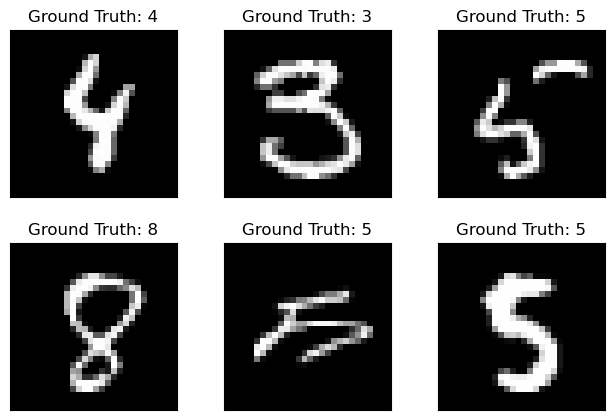

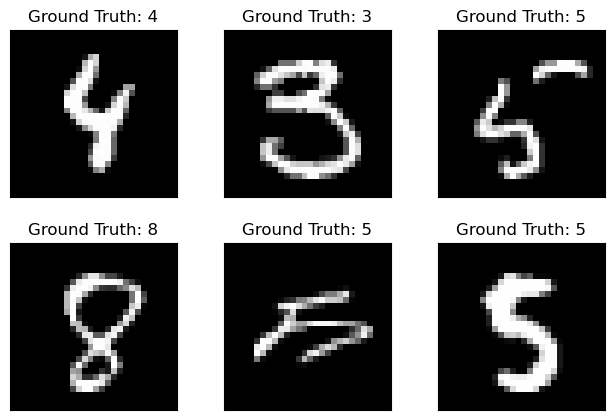

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn
from torch.nn import Module
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

In [7]:
# Setting seeds for reproducibility
torch.manual_seed(1)

In [8]:
class BiKAThreshold(Module):
    def __init__(self):
        super(BiKAThreshold, self).__init__()

        self.bn   = nn.BatchNorm1d(1)
        self.sign = qnn.QuantIdentity(
                         quant_type='binary',
                         scaling_impl_type='const',
                         bit_width=1,
                         min_val=-1.0,
                         max_val=1.0, 
                         return_quant_tensor=False
                         )

    def forward(self, x):

        out = self.sign(self.bn(x)) 
        
        return out

In [26]:
class BiKANeuron(Module):
    def __init__(self, in_channels):
        super(BiKANeuron, self).__init__()

        self.in_channels = in_channels
        
        self.Thresholds = nn.ModuleList()
        for index in range(self.in_channels):
            self.Thresholds.append(BiKAThreshold())

    def forward(self, x):

        batch_size = x.size(dim=0)
        in_size = x.size(dim=1)
        out = x.reshape((in_size, batch_size, 1))
        for index in range(self.in_channels):
            out[index] = self.Thresholds[index](out[index])
        out = out.reshape((batch_size, in_size))
        out = out.sum(1)
        
        return out

In [9]:
class BiKANeuron(Module):
    def __init__(self, in_channels):
        super(BiKANeuron, self).__init__()

        self.in_channels = in_channels
        
        self.Thresholds = nn.ModuleList()
        for index in range(self.in_channels):
            self.Thresholds.append(BiKAThreshold())

    def forward(self, x):
        batch_size = x.size(dim=0)
        in_size = x.size(dim=1)
        out = x.reshape((in_size, batch_size, 1))
        
        # Instead of modifying out in-place, create a list to store the results
        threshold_results = []
        for index in range(self.in_channels):
            threshold_results.append(self.Thresholds[index](out[index]))
        
        # Stack the results back into a tensor
        out = torch.stack(threshold_results, dim=0)
        
        out = out.reshape((batch_size, in_size))
        out = out.sum(1)
        
        return out

In [10]:
class BiKALinear(Module):
    def __init__(self, in_channels, out_channels):
        super(BiKALinear, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.Neurons = nn.ModuleList()
        for index in range(self.out_channels):
            self.Neurons.append(BiKANeuron(self.in_channels))

    def forward(self, x):

        results = []
        for index in range(self.out_channels):
            results.append(self.Neurons[index](x))
            final_out = torch.stack(results, dim=1)
            
        return final_out

In [11]:
class BiKA(Module):
    def __init__(self):
        super(BiKA, self).__init__()
        
        self.fc0 = BiKALinear(784, 10)
        self.fc1 = BiKALinear(10, 10)

    def forward(self, x):

        out = x.reshape(x.shape[0], -1)
        out = self.fc0(out)
        out = self.fc1(out)
        
        return out

In [12]:
model = BiKA()

In [13]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        #inputs, target = inputs.cuda(), target.cuda()
        inputs, target = Variable(inputs), Variable(target)
        
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        
        optimizer.zero_grad()
        loss = criterion(outputs,target)
 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.numpy()) 
           
    return losses

In [14]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            #inputs, target = inputs.cuda(), target.cuda()
            inputs, target = Variable(inputs),Variable(target)
            output = model(inputs)
            #output = torch.sigmoid(output_orig)  
            _,pred = torch.max(output,1)
            # compare against a threshold of 0.5 to generate 0/1
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [15]:
num_epochs = 10
learn_rate = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [16]:
# loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss = 2.404433 test accuracy = 0.096700:  10%| | 1/10 [50:31<7:34:40, 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

In [ ]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [ ]:
test(model, data_loader_test)